# Time Domain Tutorial #1
## State Space Oscillators: Spectral Decomposition

ASSC 2023

Emily Stephen, adapted from Alex He's `somata/Examples/IterOsc_example.py`

In this tutorial, we will use the SSO framework for spectral decomposition, using the iterative oscillator decomposition algorithm<sup>1</sup>.




[1] Beck, A. M., He, M., Gutierrez, R. G., & Purdon, P. L. (2022). An iterative search algorithm to identify oscillatory dynamics in neurophysiological time series. bioRxiv, 2022-10. [10.1101/2022.10.30.514422](https://doi.org/10.1101/2022.10.30.514422)

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from somata.iterative_oscillator import IterativeOscillatorModel as IterOsc
from somata.iterative_oscillator.helper_functions import simulate_matsuda, sim_to_osc_object
from somata.multitaper import fast_psd_multitaper

### Simulate a SSO with two oscillations, 2Hz and 10Hz

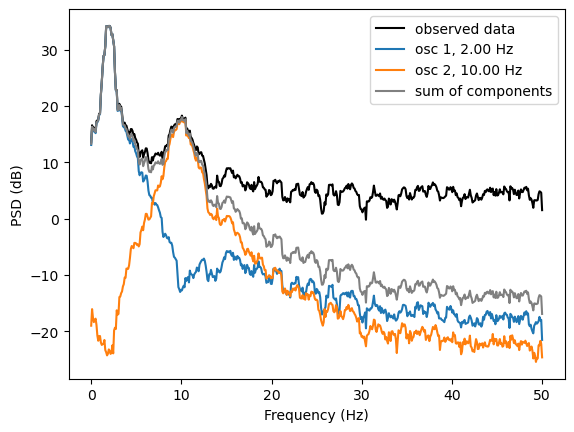

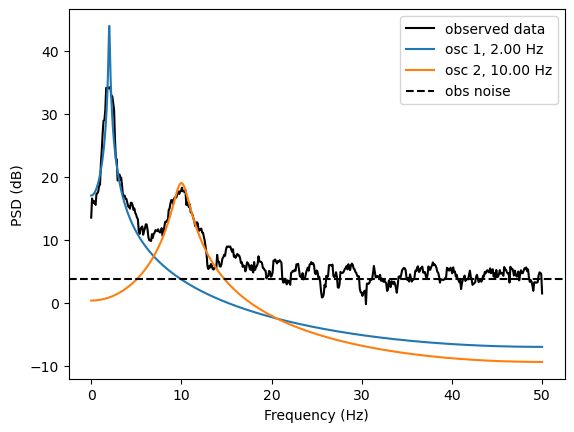

In [2]:
fs = 100  # sampling frequency (Hz)
noise_start = 30
osc1 = {'a': 0.996, 'q': 0.4, 'f': 2}  # set simulating parameters for slow oscillation
osc2 = {'a': 0.95, 'q': 0.2, 'f': 10}  # set simulating parameters for alpha oscillation
y, param_list, ob_noise = simulate_matsuda([osc1, osc2], R=1.2, Fs=fs, T=10)
sim_osc0, sim_x0 = sim_to_osc_object(y, param_list)  # save simulations as Osc object to pass into plotting functions

h_i_act, f_hz_act = sim_osc0.visualize_freq('actual')
h_i_theo, f_hz_theo = sim_osc0.visualize_freq('theoretical')

### Use the analytic signal to compute the instantaneous amplitude and phase in the 8-12Hz band

(0.0, 50.0)

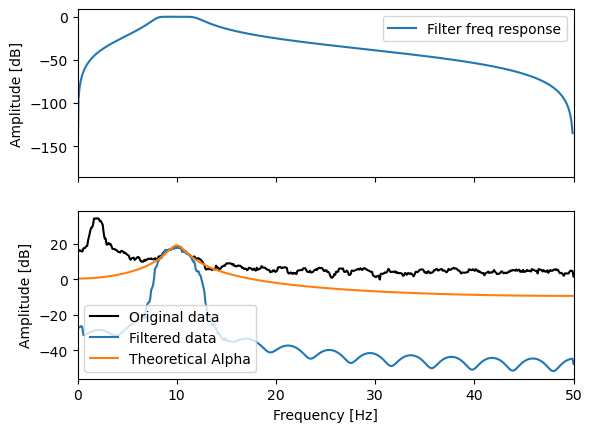

In [3]:
band = [8,12]

# Filter in the band (different filters and settings will have different properties)
b, a = signal.butter(4, band, btype='bandpass', fs=fs)
fh_hz, h = signal.freqz(b, a, fs=fs)
y_filt = signal.filtfilt(b, a, y)

# Plot the filter frequency response and the spectrum of the filtered data
Sy_mt, fy_hz = fast_psd_multitaper(y, fs, 0, fs / 2, 1)
Sy_filt_mt, fy_filt_hz = fast_psd_multitaper(y_filt, fs, 0, fs / 2, 1)


fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(fh_hz, 10 * np.log10(abs(h)), label='Filter freq response')
axs[0].legend()
axs[0].set_ylabel('Amplitude [dB]')
axs[1].plot(fy_hz, 10 * np.log10(Sy_mt), color='k', label='Original data')
axs[1].plot(fy_filt_hz, 10 * np.log10(Sy_filt_mt), label='Filtered data')
axs[1].plot(f_hz_theo, 10 * np.log10(h_i_theo[1]), label='Theoretical Alpha')
axs[1].set_xlabel('Frequency [Hz]')
axs[1].set_ylabel('Amplitude [dB]')
axs[1].legend()
axs[1].set_xlim([0, 50])

(0.0, 3.0)

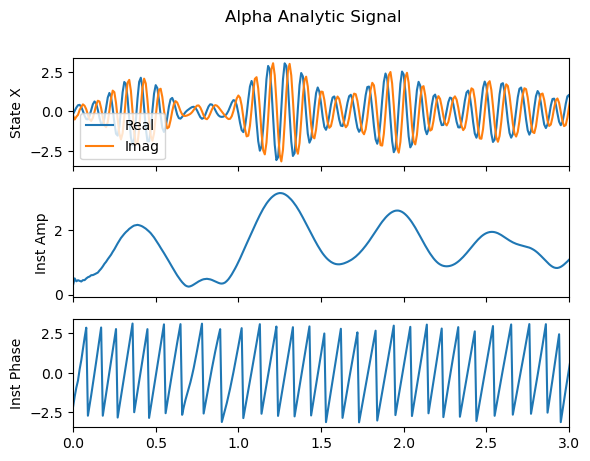

In [4]:
# Compute the analytic signal
y_filt_analytic = signal.hilbert(y_filt)

# Get instantaneous amplitude and phase
analytic_amp = np.abs(y_filt_analytic)
analytic_phase = np.angle(y_filt_analytic)

# Plot the results
ta = np.arange(y.shape[0]) / fs
[fig,axs] = plt.subplots(3,1,sharex=True)
fig.suptitle('Alpha Analytic Signal')
axs[0].plot(ta,np.real(y_filt_analytic),
            ta, np.imag(y_filt_analytic))
axs[0].legend(['Real','Imag'])
axs[0].set_ylabel('State X')
axs[1].plot(ta,analytic_amp)
axs[1].set_ylabel('Inst Amp')
axs[2].plot(ta,analytic_phase)
axs[2].set_ylabel('Inst Phase')
axs[0].set_xlim([0,3])

### Run the iterative oscillator decomposition algorithm and plot the results

In [5]:
# Initialize Iterative Oscillator object
io_orig = IterOsc(y, fs, noise_start, burg_flag=False, verbose=False) 

# Run through iterations to fit model
io_orig.iterate(osc_range=7, plot_innov=False, verbose=False)
# osc_range is maximum number of total oscillators, set to default.
# plot_innov=True plots innovation spectrum and AR fitting during iterations
# verbose=True prints parameters throughout the method

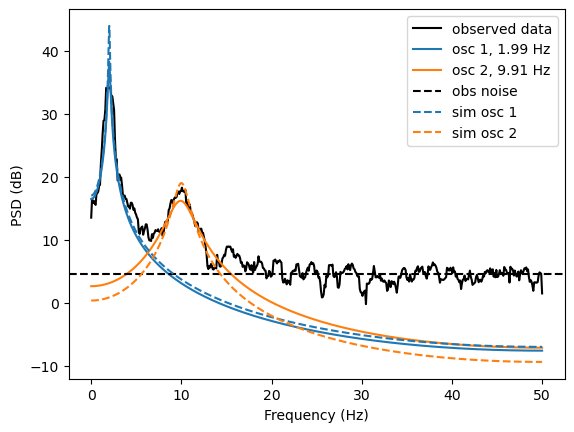

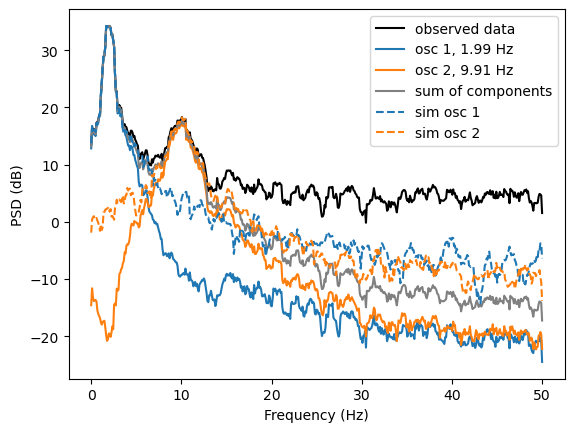

In [6]:
# Plot frequency domain (from parameters and from estimated x_t)
best_io = io_orig.fitted_osc[io_orig.knee_index]
for version in ['theoretical', 'actual']:
    _ = best_io.visualize_freq(version, y=y, sim_osc=sim_osc0,
                                             sim_x=sim_x0)

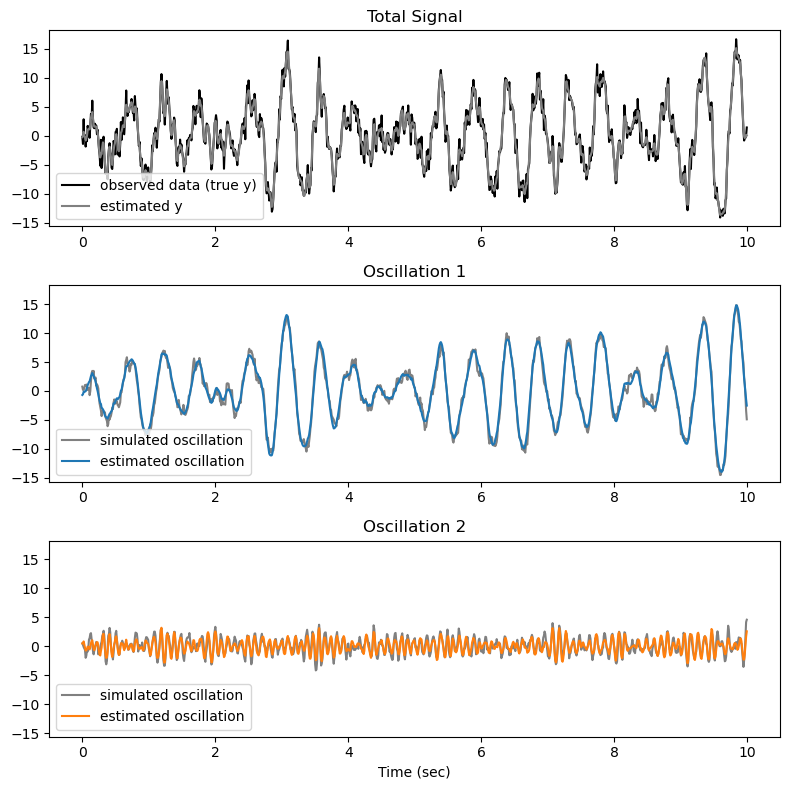

In [7]:
# Plot time domain estimated x_t
_ = best_io.visualize_time(y=y, sim_x=sim_x0)

Text(0.5, 1.0, 'Log Likelihood')

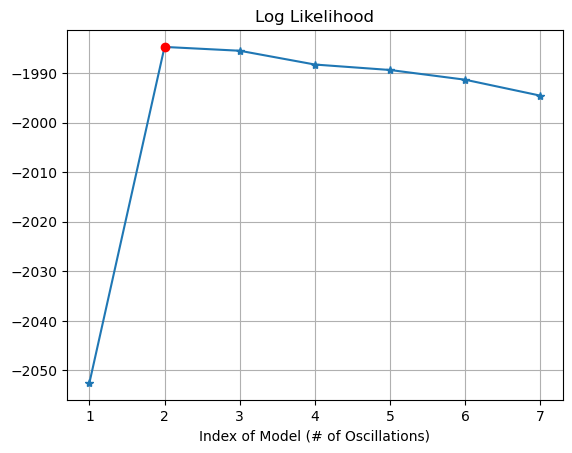

In [8]:
# Plot likelihood and selected model (may not be the highest likelihood)
plt.figure()
plt.plot(range(1, len(io_orig.fitted_osc) + 1), io_orig.ll, '-*', label='__nolegend__')
plt.scatter(io_orig.knee_index + 1, io_orig.ll[io_orig.knee_index], color='red', zorder=2,
            label='model selected with knee')
plt.xlabel('Index of Model (# of Oscillations)')
plt.grid('on')
plt.title('Log Likelihood')

### Plot details about the alpha oscillator, with instantaneous phase and amplitude

(0.0, 3.0)

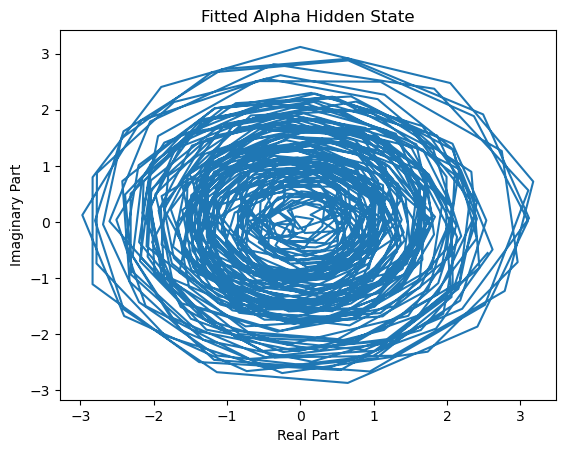

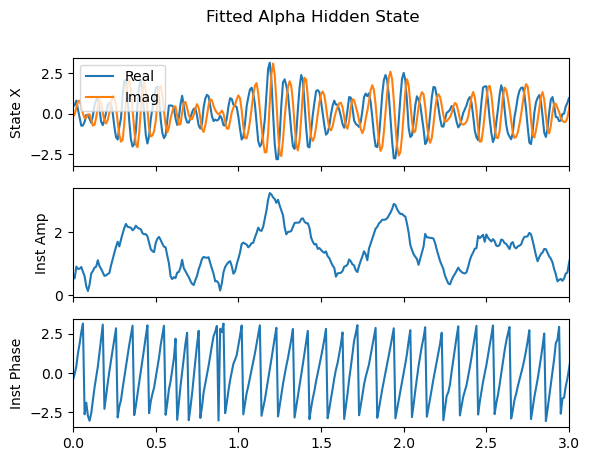

In [9]:
# Plot the hidden state, instantaneous amplitude and phase for the 10hz oscillator
kalman_out = best_io.kalman_filt_smooth(y=y[None,:],return_dict=True)
x_alpha_fit = kalman_out['x_t_n'][2:4, 1:] # drop the first time index

# Compute instantaneous amplitude and phase
from math import atan2
alpha_phase_fit = np.array([atan2(x_alpha_fit[1,i],x_alpha_fit[0,i]) for i in range(len(ta))])
alpha_amp_fit = np.sqrt(x_alpha_fit[0,:]**2 + x_alpha_fit[1,:]**2)

plt.figure()
plt.plot(x_alpha_fit[0],x_alpha_fit[1])
plt.title('Fitted Alpha Hidden State')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')

[fig,axs] = plt.subplots(3,1,sharex=True)
fig.suptitle('Fitted Alpha Hidden State')
axs[0].plot(ta,x_alpha_fit.T)
axs[0].legend(['Real','Imag'])
axs[0].set_ylabel('State X')
axs[1].plot(ta,alpha_amp_fit)
axs[1].set_ylabel('Inst Amp')
axs[2].plot(ta,alpha_phase_fit)
axs[2].set_ylabel('Inst Phase')
axs[0].set_xlim([0,3])

### Compare the true simulated oscillation vs. analytic signal vs. the SSO inference

(0.0, 3.0)

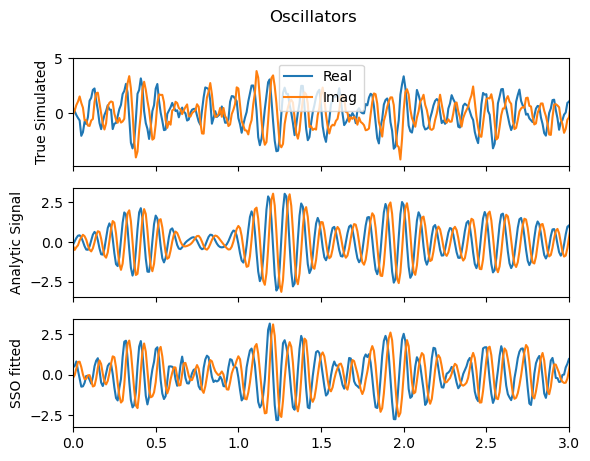

In [10]:
x_alpha_true = sim_x0[2:,:]
alpha_phase_true = np.array([atan2(x_alpha_true[1,i],x_alpha_true[0,i]) for i in range(len(ta))])
alpha_amp_true = np.sqrt(x_alpha_true[0,:]**2 + x_alpha_true[1,:]**2)

# Compare the oscillators
[fig,axs] = plt.subplots(3,1,sharex=True)
fig.suptitle('Oscillators')
axs[0].plot(ta,x_alpha_true.T)
axs[0].set_ylabel('True Simulated')
axs[0].legend(['Real','Imag'])

axs[1].plot(ta,np.real(y_filt_analytic),
            ta, np.imag(y_filt_analytic))
axs[1].set_ylabel('Analytic Signal')

axs[2].plot(ta,x_alpha_fit.T)
axs[2].set_ylabel('SSO fitted')
axs[2].set_xlim([0,3])

(0.0, 3.0)

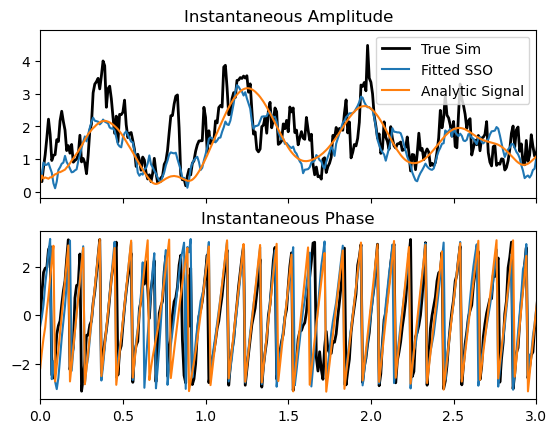

In [11]:
# Compare the amplitude and phase
[fig,axs] = plt.subplots(2,1,sharex=True)
axs[0].plot(ta,alpha_amp_true, color='k', linewidth=2, label='True Sim')
axs[0].plot(ta,alpha_amp_fit, label='Fitted SSO')
axs[0].plot(ta,analytic_amp, label='Analytic Signal')
axs[0].set_title('Instantaneous Amplitude')
axs[0].legend()

axs[1].plot(ta,alpha_phase_true, color='k', linewidth=2, label='True Sim')
axs[1].plot(ta,alpha_phase_fit, label='Fitted SSO')
axs[1].plot(ta,analytic_phase, label='Analytic Signal')
axs[1].set_title('Instantaneous Phase')
axs[0].set_xlim([0,3])
